#### CSC 180-01 Intelligent Systems (Fall 2022)
##### Group: Jonathan Jakab,  Jacob Hallum, Mahdi Noureddine
##### California State University, Sacramento

# Project 4: It's My Money!
## The Defence Against Online Payment Fraud

# 
### GPU Memory Allocation.

In [1]:
import tensorflow as tf

# Sets max GPU memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=18432)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [1]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

# 
# Imports
Contains the imports for the applications. 

In [2]:
import os
import csv
import json
import shutil
import numpy as np
import pandas as pd

from collections.abc import Sequence

import matplotlib.pyplot as plt

from sklearn import datasets, metrics, svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# 
# Helpful Functions for Tensorflow (from Labs)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [29]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
    
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 
# Input/Output Setup
* Checks if directories for data input and output are created/ create the directories.
* Reads in data from the CSV file located in the data directory

In [4]:
# Get current working directory
current_directory = os.getcwd()

# Sets up input file locations for the data input.
dataPath = "./data/"
dataDirectory = os.path.join(current_directory, dataPath)

# Sets up locations for the data output location.
savePath = "./output/"
saveDirectory = os.path.join(current_directory, savePath)

if os.path.exists(saveDirectory):
    print('Directory Exists')
else:
    os.makedirs(saveDirectory)

Directory Exists


# 
# Data Processing
## Read in data from onlinefraud.csv
### Columns in dataset

* step: represents a unit of time where 1 step equals 1 hour.
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction
* isFlaggedFraud: 

In [32]:
data = pd.read_csv(dataDirectory+'onlinefraud.csv',delimiter = ',', encoding = "utf-8")
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


# 
## Missing and Null Values In Dataset
* Check for any Missing or Null Values in the Dataset

In [33]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# 
## Duplicate Records In Dataset
* Check for any Duplicate Records in the Dataset
* Drop any Duplicate Records in the Dataset
* Note: Use Reset_index to reindex the dataset to remove gaps created from data removal.

In [34]:
num_duplicates = data.duplicated()
print("Number of Duplicates:", num_duplicates.sum())

Number of Duplicates: 0


In [35]:
data.drop_duplicates(inplace = True)
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


# 
## Extra Information About Dataset

In [36]:
print(data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [37]:
print(data.isFraud.value_counts())

0    6354407
1       8213
Name: isFraud, dtype: int64


### Here we encode the results column so that attacks are 1 and normal is 0

In [38]:
binary_intrusion_data = encode_text_index(data, 'isFraud')
binary_intrusion_data

array([0, 1], dtype=int64)

# 
# Data Prepping

## Encode Categorical Features
### Selecting Features
Using the datasets documentaiton, we selected features we feel hold information about a transaction which can be necessary for training. These features are likely non-numeric. Therfore we will encode them to be numeric using encode_text_dummy()
* isFraud: fraud transaction

In [11]:
encode_text_dummy(data, 'type')
data

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type-CASH_IN,type-CASH_OUT,type-DEBIT,type-PAYMENT,type-TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,0,1


# 
## Normalize Raw Values
### Get the Types for each column and drop any unnecessary columns.

In [12]:
data.dtypes

step                int64
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type-CASH_IN        uint8
type-CASH_OUT       uint8
type-DEBIT          uint8
type-PAYMENT        uint8
type-TRANSFER       uint8
dtype: object

In [13]:
data.drop(['nameOrig','nameDest','oldbalanceDest','newbalanceDest'], axis = 1, inplace = True)
data

,step,amount,oldbalanceOrg,newbalanceOrig,isFraud,isFlaggedFraud,type-CASH_IN,type-CASH_OUT,type-DEBIT,type-PAYMENT,type-TRANSFER
0,1,9839.64,170136.00,160296.36,0,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0,0,0,0,0,1,0
2,1,181.00,181.00,0.00,1,0,0,0,0,0,1
3,1,181.00,181.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,1,0,0,1,0,0,0
6362616,743,6311409.28,6311409.28,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,6311409.28,0.00,1,0,0,1,0,0,0
6362618,743,850002.52,850002.52,0.00,1,0,0,0,0,0,1


In [14]:
data.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
isFraud             int64
isFlaggedFraud      int64
type-CASH_IN        uint8
type-CASH_OUT       uint8
type-DEBIT          uint8
type-PAYMENT        uint8
type-TRANSFER       uint8
dtype: object

In [15]:
dataset_length = data.columns.get_loc('isFraud')
print('The length of the dataset is: ', dataset_length)

The length of the dataset is:  4


### Normalize every Column

In [16]:
for i in range (dataset_length):
    encode_numeric_zscore(data, data.columns[i])
    print(i)
data

0
1
2
3


,step,amount,oldbalanceOrg,newbalanceOrig,isFraud,isFlaggedFraud,type-CASH_IN,type-CASH_OUT,type-DEBIT,type-PAYMENT,type-TRANSFER
0,-1.703041,-0.281560,-0.229810,-0.237622,0,0,0,0,0,1,0
1,-1.703041,-0.294767,-0.281359,-0.285812,0,0,0,0,0,1,0
2,-1.703041,-0.297555,-0.288654,-0.292442,1,0,0,0,0,0,1
3,-1.703041,-0.297555,-0.288654,-0.292442,1,0,0,1,0,0,0
4,-1.703041,-0.278532,-0.274329,-0.282221,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,3.510123,0.264665,-0.171108,-0.292442,1,0,0,1,0,0,0
6362616,3.510123,10.153952,1.896491,-0.292442,1,0,0,0,0,0,1
6362617,3.510123,10.153952,1.896491,-0.292442,1,0,0,1,0,0,0
6362618,3.510123,1.109765,0.005581,-0.292442,1,0,0,0,0,0,1


# 
## CHECKPOINT: Save Prepped Data To File
#### This will make it easier for later training and testing.

In [17]:
data.to_csv(saveDirectory + 'results.csv', index=False)
data

,step,amount,oldbalanceOrg,newbalanceOrig,isFraud,isFlaggedFraud,type-CASH_IN,type-CASH_OUT,type-DEBIT,type-PAYMENT,type-TRANSFER
0,-1.703041,-0.281560,-0.229810,-0.237622,0,0,0,0,0,1,0
1,-1.703041,-0.294767,-0.281359,-0.285812,0,0,0,0,0,1,0
2,-1.703041,-0.297555,-0.288654,-0.292442,1,0,0,0,0,0,1
3,-1.703041,-0.297555,-0.288654,-0.292442,1,0,0,1,0,0,0
4,-1.703041,-0.278532,-0.274329,-0.282221,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,3.510123,0.264665,-0.171108,-0.292442,1,0,0,1,0,0,0
6362616,3.510123,10.153952,1.896491,-0.292442,1,0,0,0,0,0,1
6362617,3.510123,10.153952,1.896491,-0.292442,1,0,0,1,0,0,0
6362618,3.510123,1.109765,0.005581,-0.292442,1,0,0,0,0,0,1


# 
## CHECKPOINT: Load prepped data to file
#### This will make it easier for later training and testing.

In [7]:
ready_to_train = pd.read_csv(saveDirectory+'results.csv', delimiter = ',', encoding = "utf-8")
ready_to_train

,step,amount,oldbalanceOrg,newbalanceOrig,isFraud,isFlaggedFraud,type-CASH_IN,type-CASH_OUT,type-DEBIT,type-PAYMENT,type-TRANSFER
0,-1.703041,-0.281560,-0.229810,-0.237622,0,0,0,0,0,1,0
1,-1.703041,-0.294767,-0.281359,-0.285812,0,0,0,0,0,1,0
2,-1.703041,-0.297555,-0.288654,-0.292442,1,0,0,0,0,0,1
3,-1.703041,-0.297555,-0.288654,-0.292442,1,0,0,1,0,0,0
4,-1.703041,-0.278532,-0.274329,-0.282221,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,3.510123,0.264665,-0.171108,-0.292442,1,0,0,1,0,0,0
6362616,3.510123,10.153952,1.896491,-0.292442,1,0,0,0,0,0,1
6362617,3.510123,10.153952,1.896491,-0.292442,1,0,0,1,0,0,0
6362618,3.510123,1.109765,0.005581,-0.292442,1,0,0,0,0,0,1


# 
# Split data into Training and Test Data.
### Alterable Values
* Test_Size: Size of the X & Y Test dataset. (percentage as decimal)
* random_state:
* Dense:
* Epochs: number of attemptsassuming model doesnt early stop on its own 

In [8]:
x,y = to_xy(ready_to_train,"isFraud")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5090096, 10)
(5090096, 2)
(1272524, 10)
(1272524, 2)


# 
# Neural Network Models

# Fully-Connected Neural Network Model 
### (Relu + Adam + 2 Hidden Layers, 20, 10 Neurons)
1. **relu_adam_model_FC.add(Dense(20, input_dim=x.shape[1], activation='relu'))   # Hidden Layer 1, 20 Neurons**
2. **relu_adam_model_FC.add(Dense(10, activation='relu'))   # Hidden Layer 2, 10 Neurons**
3. **relu_adam_model_FC.add(Dense(y.shape[1], activation='softmax'))**

In [7]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/relu_adam_model_FC.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_adam_model_FC = Sequential()

    relu_adam_model_FC.add(Dense(20, input_dim=x_train.shape[1], activation='relu'))
    relu_adam_model_FC.add(Dense(10, activation='relu'))
    relu_adam_model_FC.add(Dense(y_train.shape[1], activation='softmax'))

    relu_adam_model_FC.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    relu_adam_model_FC.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 322s - loss: 0.0043 - val_loss: 0.0031
Epoch 2/600
159066/159066 - 312s - loss: 0.0032 - val_loss: 0.0025
Epoch 3/600
159066/159066 - 291s - loss: 0.0031 - val_loss: 0.0030
Epoch 4/600
159066/159066 - 305s - loss: 0.0029 - val_loss: 0.0031
Epoch 5/600
159066/159066 - 307s - loss: 0.0028 - val_loss: 0.0025
Epoch 6/600
159066/159066 - 265s - loss: 0.0028 - val_loss: 0.0031
Epoch 00006: early stopping

Run:  2
Epoch 1/600
159066/159066 - 285s - loss: 0.0041 - val_loss: 0.0036
Epoch 2/600
159066/159066 - 324s - loss: 0.0035 - val_loss: 0.0030
Epoch 3/600
159066/159066 - 295s - loss: 0.0033 - val_loss: 0.0029
Epoch 4/600
159066/159066 - 302s - loss: 0.0031 - val_loss: 0.0027
Epoch 5/600
159066/159066 - 277s - loss: 0.0030 - val_loss: 0.0026
Epoch 6/600
159066/159066 - 285s - loss: 0.0030 - val_loss: 0.0025
Epoch 7/600
159066/159066 - 321s - loss: 0.0028 - val_loss: 0.0026
Epoch 8/600
159066/159066 - 311s - loss: 0.0027 - val_loss: 0.0024
Epoch 9/600
1590

In [17]:
relu_adam_model_FC.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________


# 
### (Sigmoid + Adam + 2 Hidden Layers, 20, 10 Neurons)
1. **sigmoid_adam_model_FC.add(Dense(20, input_dim=x.shape[1], activation='sigmoid'))   # Hidden Layer 1, 20 Neurons**
2. **sigmoid_adam_model_FC.add(Dense(10, activation='sigmoid'))   # Hidden Layer 2, 10 Neurons**
3. **sigmoid_adam_model_FC.add(Dense(y.shape[1], activation='softmax'))**

In [25]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/sigmoid_adam_model_FC.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    sigmoid_adam_model_FC = Sequential()

    sigmoid_adam_model_FC.add(Dense(20, input_dim=x_train.shape[1], activation='sigmoid'))
    sigmoid_adam_model_FC.add(Dense(10, activation='sigmoid'))
    sigmoid_adam_model_FC.add(Dense(y_train.shape[1], activation='softmax'))

    sigmoid_adam_model_FC.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    sigmoid_adam_model_FC.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 267s - loss: 0.0047 - val_loss: 0.0036
Epoch 2/600
159066/159066 - 280s - loss: 0.0034 - val_loss: 0.0031
Epoch 3/600
159066/159066 - 284s - loss: 0.0032 - val_loss: 0.0030
Epoch 4/600
159066/159066 - 276s - loss: 0.0031 - val_loss: 0.0030
Epoch 5/600
159066/159066 - 275s - loss: 0.0030 - val_loss: 0.0026
Epoch 6/600
159066/159066 - 301s - loss: 0.0029 - val_loss: 0.0026
Epoch 00006: early stopping

Run:  2
Epoch 1/600
159066/159066 - 286s - loss: 0.0049 - val_loss: 0.0034
Epoch 2/600
159066/159066 - 287s - loss: 0.0034 - val_loss: 0.0031
Epoch 3/600
159066/159066 - 298s - loss: 0.0032 - val_loss: 0.0029
Epoch 4/600
159066/159066 - 291s - loss: 0.0031 - val_loss: 0.0028
Epoch 5/600
159066/159066 - 274s - loss: 0.0030 - val_loss: 0.0033
Epoch 6/600
159066/159066 - 274s - loss: 0.0029 - val_loss: 0.0027
Epoch 00006: early stopping

Run:  3
Epoch 1/600
159066/159066 - 284s - loss: 0.0047 - val_loss: 0.0040
Epoch 2/600
159066/159066 - 277s - loss: 0.003

In [26]:
sigmoid_adam_model_FC.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 22        
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________


# 
### (Tanh + Adam + 2 Hidden Layers, 20, 10 Neurons)
1. **Tanh_adam_model_FC.add(Dense(20, input_dim=x.shape[1], activation='tanh'))   # Hidden Layer 1, 20 Neurons**
2. **Tanh_adam_model_FC.add(Dense(10, activation='tanh'))   # Hidden Layer 2, 10 Neurons**
3. **Tanh_adam_model_FC.add(Dense(y.shape[1], activation='softmax'))**

In [14]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/tanh_adam_model_FC.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    tanh_adam_model_FC = Sequential()

    tanh_adam_model_FC.add(Dense(20, input_dim=x_train.shape[1], activation='tanh'))
    tanh_adam_model_FC.add(Dense(10, activation='tanh'))
    tanh_adam_model_FC.add(Dense(y_train.shape[1], activation='softmax'))

    tanh_adam_model_FC.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    tanh_adam_model_FC.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 326s - loss: 0.0043 - val_loss: 0.0033
Epoch 2/600
159066/159066 - 316s - loss: 0.0034 - val_loss: 0.0031
Epoch 3/600
159066/159066 - 299s - loss: 0.0032 - val_loss: 0.0029
Epoch 4/600
159066/159066 - 294s - loss: 0.0030 - val_loss: 0.0030
Epoch 5/600
159066/159066 - 292s - loss: 0.0029 - val_loss: 0.0029
Epoch 6/600
159066/159066 - 303s - loss: 0.0028 - val_loss: 0.0025
Epoch 00006: early stopping

Run:  2
Epoch 1/600
159066/159066 - 328s - loss: 0.0042 - val_loss: 0.0032
Epoch 2/600
159066/159066 - 303s - loss: 0.0033 - val_loss: 0.0029
Epoch 3/600
159066/159066 - 311s - loss: 0.0031 - val_loss: 0.0028
Epoch 4/600
159066/159066 - 298s - loss: 0.0030 - val_loss: 0.0027
Epoch 5/600
159066/159066 - 357s - loss: 0.0029 - val_loss: 0.0025
Epoch 6/600
159066/159066 - 363s - loss: 0.0028 - val_loss: 0.0027
Epoch 00006: early stopping

Run:  3
Epoch 1/600
159066/159066 - 364s - loss: 0.0041 - val_loss: 0.0036
Epoch 2/600
159066/159066 - 318s - loss: 0.003

In [15]:
tanh_adam_model_FC.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 22        
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________


# 
## Convert the X Test & Train for CNN

In [9]:
x_train_cnn = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], 1)
input_shape = (1, x_train.shape[1], 1)

print(x_train_cnn.shape, 'training samples')
print(x_test_cnn.shape, 'testing samples')
print(input_shape)

(5090096, 1, 10, 1) training samples
(1272524, 1, 10, 1) testing samples
(1, 10, 1)


# 
# Convolutional Neural Networks (CNN)
For the convolutional layer, We must specify the following hyper-parameters :

* Number of filters
* Filter Size
* Stride
* Padding
* Activation Function/Non-Linearity


A filter is a square-shaped object that scans over the image. The more filters that we give to a convolutional layer, the more features it can detect.


## Max Pooling Layers

Max-pool layers downsample the data.  This technique can avoid overfitting.

*** Typically, you can always place a max-pool layer immediately following convolutional layer.***



# Example of Training CNNs with Tensorflow

The following sections describe how to use TensorFlow/Keras with CNNs.

* Hint: For CNN, find a way to view each connection as an image. Please refer to our lab tutorial on CNN for handling data types other than images. You may use either Conv2D or Conv1D.

https://www.mlq.ai/convolutional-neural-network-python-keras/

# 
# Convolutional Neural Network Model 

### (Relu + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [24]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/relu_adam_model_CNN.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_adam_model_CNN = Sequential()
    
    relu_adam_model_CNN.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='relu', padding='same', input_shape=input_shape))
    relu_adam_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    relu_adam_model_CNN.add(Conv2D(64, kernel_size=(1, 5), strides=(1, 1), activation='relu', padding='same', input_shape=input_shape))
    relu_adam_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    relu_adam_model_CNN.add(Flatten())
    relu_adam_model_CNN.add(Dense(1000, activation='relu'))
    relu_adam_model_CNN.add(Dropout(0.25))
    relu_adam_model_CNN.add(Dense(y_train.shape[1], activation='softmax'))

    relu_adam_model_CNN.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    relu_adam_model_CNN.fit(x_train_cnn,y_train, validation_data=(x_test_cnn,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 377s - loss: 0.0049 - val_loss: 0.0034
Epoch 2/600
159066/159066 - 373s - loss: 0.0041 - val_loss: 0.0035
Epoch 3/600
159066/159066 - 368s - loss: 0.0040 - val_loss: 0.0039
Epoch 4/600
159066/159066 - 378s - loss: 0.0039 - val_loss: 0.0034
Epoch 5/600
159066/159066 - 382s - loss: 0.0041 - val_loss: 0.0054
Epoch 6/600
159066/159066 - 382s - loss: 0.0050 - val_loss: 0.0030
Epoch 00006: early stopping

Run:  2
Epoch 1/600
159066/159066 - 480s - loss: 0.0051 - val_loss: 0.0035
Epoch 2/600
159066/159066 - 374s - loss: 0.0041 - val_loss: 0.0031
Epoch 3/600
159066/159066 - 366s - loss: 0.0040 - val_loss: 0.0037
Epoch 4/600
159066/159066 - 385s - loss: 0.0040 - val_loss: 0.0033
Epoch 5/600
159066/159066 - 393s - loss: 0.0044 - val_loss: 0.0033
Epoch 6/600
159066/159066 - 371s - loss: 0.0038 - val_loss: 0.0033
Epoch 00006: early stopping

Run:  3
Epoch 1/600
159066/159066 - 388s - loss: 0.0048 - val_loss: 0.0045
Epoch 2/600
159066/159066 - 375s - loss: 0.003

In [19]:
relu_adam_model_CNN.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 1, 10, 32)         192       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 5, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 5, 64)          10304     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)            

# 
### (Relu + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [54]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/relu_sgd_model_CNN.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_sgd_model_CNN = Sequential()
    
    relu_sgd_model_CNN.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='relu', padding='same', input_shape=input_shape))
    relu_sgd_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    relu_sgd_model_CNN.add(Conv2D(64, kernel_size=(1, 5), strides=(1, 1), activation='relu', padding='same', input_shape=input_shape))
    relu_sgd_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    relu_sgd_model_CNN.add(Flatten())
    relu_sgd_model_CNN.add(Dense(1000, activation='relu'))
    relu_sgd_model_CNN.add(Dropout(0.25))
    relu_sgd_model_CNN.add(Dense(y_train.shape[1], activation='softmax'))

    relu_sgd_model_CNN.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    relu_sgd_model_CNN.fit(x_train_cnn,y_train, validation_data=(x_test_cnn,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 356s - loss: 0.0071 - val_loss: 0.0052
Epoch 2/600
159066/159066 - 353s - loss: 0.0048 - val_loss: 0.0044
Epoch 3/600
159066/159066 - 363s - loss: 0.0043 - val_loss: 0.0041
Epoch 4/600
159066/159066 - 354s - loss: 0.0040 - val_loss: 0.0038
Epoch 5/600
159066/159066 - 359s - loss: 0.0038 - val_loss: 0.0035
Epoch 6/600
159066/159066 - 361s - loss: 0.0036 - val_loss: 0.0033
Epoch 7/600
159066/159066 - 362s - loss: 0.0034 - val_loss: 0.0034
Epoch 8/600
159066/159066 - 355s - loss: 0.0033 - val_loss: 0.0032
Epoch 00008: early stopping

Run:  2
Epoch 1/600
159066/159066 - 362s - loss: 0.0073 - val_loss: 0.0053
Epoch 2/600
159066/159066 - 351s - loss: 0.0048 - val_loss: 0.0045
Epoch 3/600
159066/159066 - 355s - loss: 0.0043 - val_loss: 0.0042
Epoch 4/600
159066/159066 - 355s - loss: 0.0040 - val_loss: 0.0037
Epoch 5/600
159066/159066 - 361s - loss: 0.0038 - val_loss: 0.0035
Epoch 6/600
159066/159066 - 356s - loss: 0.0036 - val_loss: 0.0062
Epoch 7/600
1590

In [20]:
relu_sgd_model_CNN.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 1, 10, 32)         192       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 1, 5, 32)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 5, 64)          10304     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)            

# 
### (Sigmoid + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [8]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/sigmoid_adam_model_CNN.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    sigmoid_adam_model_CNN = Sequential()
    
    sigmoid_adam_model_CNN.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='sigmoid', padding='same', input_shape=input_shape))
    sigmoid_adam_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    sigmoid_adam_model_CNN.add(Conv2D(64, kernel_size=(1, 5), strides=(1, 1), activation='sigmoid', padding='same', input_shape=input_shape))
    sigmoid_adam_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    sigmoid_adam_model_CNN.add(Flatten())
    sigmoid_adam_model_CNN.add(Dense(1000, activation='sigmoid'))
    sigmoid_adam_model_CNN.add(Dropout(0.25))
    sigmoid_adam_model_CNN.add(Dense(y_train.shape[1], activation='softmax'))

    sigmoid_adam_model_CNN.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    sigmoid_adam_model_CNN.fit(x_train_cnn,y_train, validation_data=(x_test_cnn,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 469s - loss: 0.0050 - val_loss: 0.0037
Epoch 2/600
159066/159066 - 497s - loss: 0.0037 - val_loss: 0.0032
Epoch 3/600
159066/159066 - 498s - loss: 0.0033 - val_loss: 0.0042
Epoch 4/600
159066/159066 - 481s - loss: 0.0032 - val_loss: 0.0026
Epoch 5/600
159066/159066 - 481s - loss: 0.0032 - val_loss: 0.0025
Epoch 6/600
159066/159066 - 459s - loss: 0.0032 - val_loss: 0.0030
Epoch 7/600
159066/159066 - 401s - loss: 0.0031 - val_loss: 0.0033
Epoch 8/600
159066/159066 - 432s - loss: 0.0030 - val_loss: 0.0025
Epoch 9/600
159066/159066 - 424s - loss: 0.0030 - val_loss: 0.0029
Epoch 00009: early stopping

Run:  2
Epoch 1/600
159066/159066 - 382s - loss: 0.0050 - val_loss: 0.0035
Epoch 2/600
159066/159066 - 386s - loss: 0.0036 - val_loss: 0.0031
Epoch 3/600
159066/159066 - 395s - loss: 0.0033 - val_loss: 0.0035
Epoch 4/600
159066/159066 - 419s - loss: 0.0032 - val_loss: 0.0025
Epoch 5/600
159066/159066 - 383s - loss: 0.0031 - val_loss: 0.0024
Epoch 6/600
1590

In [21]:
sigmoid_adam_model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 10, 32)         192       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 5, 64)          10304     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              129000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)             

# 
### (Sigmoid + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [21]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/sigmoid_sgd_model_CNN.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    sigmoid_sgd_model_CNN = Sequential()
    
    sigmoid_sgd_model_CNN.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='sigmoid', padding='same', input_shape=input_shape))
    sigmoid_sgd_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    sigmoid_sgd_model_CNN.add(Conv2D(64, kernel_size=(1, 5), strides=(1, 1), activation='sigmoid', padding='same', input_shape=input_shape))
    sigmoid_sgd_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    sigmoid_sgd_model_CNN.add(Flatten())
    sigmoid_sgd_model_CNN.add(Dense(1000, activation='sigmoid'))
    sigmoid_sgd_model_CNN.add(Dropout(0.25))
    sigmoid_sgd_model_CNN.add(Dense(y_train.shape[1], activation='softmax'))

    sigmoid_sgd_model_CNN.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    sigmoid_sgd_model_CNN.fit(x_train_cnn,y_train, validation_data=(x_test_cnn,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 444s - loss: 0.0101 - val_loss: 0.0098
Epoch 2/600
159066/159066 - 421s - loss: 0.0100 - val_loss: 0.0098
Epoch 3/600
159066/159066 - 423s - loss: 0.0100 - val_loss: 0.0098
Epoch 4/600
159066/159066 - 446s - loss: 0.0100 - val_loss: 0.0098
Epoch 5/600
159066/159066 - 435s - loss: 0.0100 - val_loss: 0.0097
Epoch 6/600
159066/159066 - 423s - loss: 0.0100 - val_loss: 0.0098
Epoch 00006: early stopping

Run:  2
Epoch 1/600
159066/159066 - 471s - loss: 0.0101 - val_loss: 0.0099
Epoch 2/600
159066/159066 - 452s - loss: 0.0100 - val_loss: 0.0098
Epoch 3/600
159066/159066 - 435s - loss: 0.0100 - val_loss: 0.0098
Epoch 4/600
159066/159066 - 440s - loss: 0.0100 - val_loss: 0.0098
Epoch 5/600
159066/159066 - 480s - loss: 0.0100 - val_loss: 0.0099
Epoch 6/600
159066/159066 - 460s - loss: 0.0100 - val_loss: 0.0098
Epoch 00006: early stopping

Run:  3
Epoch 1/600
159066/159066 - 435s - loss: 0.0101 - val_loss: 0.0098
Epoch 2/600
159066/159066 - 450s - loss: 0.010

In [22]:
sigmoid_sgd_model_CNN.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1, 10, 32)         192       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 5, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 5, 64)          10304     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)            

# 
### (Tanh + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [17]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/tanh_adam_model_CNN.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    tanh_adam_model_CNN = Sequential()
    
    tanh_adam_model_CNN.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='tanh', padding='same', input_shape=input_shape))
    tanh_adam_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    tanh_adam_model_CNN.add(Conv2D(64, kernel_size=(1, 5), strides=(1, 1), activation='tanh', padding='same', input_shape=input_shape))
    tanh_adam_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    tanh_adam_model_CNN.add(Flatten())
    tanh_adam_model_CNN.add(Dense(1000, activation='tanh'))
    tanh_adam_model_CNN.add(Dropout(0.25))
    tanh_adam_model_CNN.add(Dense(y_train.shape[1], activation='softmax'))

    tanh_adam_model_CNN.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    tanh_adam_model_CNN.fit(x_train_cnn,y_train, validation_data=(x_test_cnn,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 522s - loss: 0.0045 - val_loss: 0.0050
Epoch 2/600
159066/159066 - 503s - loss: 0.0037 - val_loss: 0.0028
Epoch 3/600
159066/159066 - 473s - loss: 0.0035 - val_loss: 0.0034
Epoch 4/600
159066/159066 - 490s - loss: 0.0034 - val_loss: 0.0033
Epoch 5/600
159066/159066 - 428s - loss: 0.0033 - val_loss: 0.0033
Epoch 6/600
159066/159066 - 485s - loss: 0.0033 - val_loss: 0.0036
Epoch 7/600
159066/159066 - 522s - loss: 0.0033 - val_loss: 0.0029
Epoch 00007: early stopping

Run:  2
Epoch 1/600
159066/159066 - 493s - loss: 0.0044 - val_loss: 0.0036
Epoch 2/600
159066/159066 - 426s - loss: 0.0037 - val_loss: 0.0046
Epoch 3/600
159066/159066 - 415s - loss: 0.0036 - val_loss: 0.0030
Epoch 4/600
159066/159066 - 421s - loss: 0.0035 - val_loss: 0.0031
Epoch 5/600
159066/159066 - 430s - loss: 0.0035 - val_loss: 0.0028
Epoch 6/600
159066/159066 - 449s - loss: 0.0034 - val_loss: 0.0026
Epoch 00006: early stopping

Run:  3
Epoch 1/600
159066/159066 - 457s - loss: 0.004

In [18]:
tanh_adam_model_CNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 10, 32)         192       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 5, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 5, 64)          10304     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)             

# 
### (Tanh + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [19]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/tanh_sgd_model_CNN.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    tanh_sgd_model_CNN = Sequential()
    
    tanh_sgd_model_CNN.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='tanh', padding='same', input_shape=input_shape))
    tanh_sgd_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    tanh_sgd_model_CNN.add(Conv2D(64, kernel_size=(1, 5), strides=(1, 1), activation='tanh', padding='same', input_shape=input_shape))
    tanh_sgd_model_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    tanh_sgd_model_CNN.add(Flatten())
    tanh_sgd_model_CNN.add(Dense(1000, activation='tanh'))
    tanh_sgd_model_CNN.add(Dropout(0.25))
    tanh_sgd_model_CNN.add(Dense(y_train.shape[1], activation='softmax'))

    tanh_sgd_model_CNN.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    tanh_sgd_model_CNN.fit(x_train_cnn,y_train, validation_data=(x_test_cnn,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 414s - loss: 0.0065 - val_loss: 0.0049
Epoch 2/600
159066/159066 - 440s - loss: 0.0045 - val_loss: 0.0043
Epoch 3/600
159066/159066 - 448s - loss: 0.0041 - val_loss: 0.0038
Epoch 4/600
159066/159066 - 431s - loss: 0.0038 - val_loss: 0.0036
Epoch 5/600
159066/159066 - 426s - loss: 0.0036 - val_loss: 0.0033
Epoch 6/600
159066/159066 - 461s - loss: 0.0034 - val_loss: 0.0032
Epoch 7/600
159066/159066 - 418s - loss: 0.0033 - val_loss: 0.0030
Epoch 8/600
159066/159066 - 396s - loss: 0.0032 - val_loss: 0.0029
Epoch 00008: early stopping

Run:  2
Epoch 1/600
159066/159066 - 395s - loss: 0.0068 - val_loss: 0.0050
Epoch 2/600
159066/159066 - 396s - loss: 0.0046 - val_loss: 0.0042
Epoch 3/600
159066/159066 - 409s - loss: 0.0041 - val_loss: 0.0039
Epoch 4/600
159066/159066 - 497s - loss: 0.0039 - val_loss: 0.0037
Epoch 5/600
159066/159066 - 430s - loss: 0.0036 - val_loss: 0.0037
Epoch 6/600
159066/159066 - 419s - loss: 0.0035 - val_loss: 0.0034
Epoch 7/600
1590

In [20]:
tanh_sgd_model_CNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 10, 32)         192       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 5, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 5, 64)          10304     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)             

# 
### (Relu + Adam + 1 Convolution Layers with 64 kernals + Kernal Size: 1x3)

In [9]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/relu_adam_model_diff_CNN.hdf5", verbose=0, save_best_only=True)

# Run model training multiple times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_adam_model_diff_CNN = Sequential()
    
    relu_adam_model_diff_CNN.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), activation='relu', padding='same', input_shape=input_shape))
    relu_adam_model_diff_CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    relu_adam_model_diff_CNN.add(Flatten())
    relu_adam_model_diff_CNN.add(Dense(1000, activation='relu'))
    relu_adam_model_diff_CNN.add(Dropout(0.25))
    relu_adam_model_diff_CNN.add(Dense(y_train.shape[1], activation='softmax'))

    relu_adam_model_diff_CNN.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    relu_adam_model_diff_CNN.fit(x_train_cnn,y_train, validation_data=(x_test_cnn,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)


Run:  1
Epoch 1/600
159066/159066 - 339s - loss: 0.0039 - val_loss: 0.0027
Epoch 2/600
159066/159066 - 324s - loss: 0.0033 - val_loss: 0.0034
Epoch 3/600
159066/159066 - 322s - loss: 0.0031 - val_loss: 0.0029
Epoch 4/600
159066/159066 - 327s - loss: 0.0032 - val_loss: 0.0031
Epoch 5/600
159066/159066 - 330s - loss: 0.0031 - val_loss: 0.0025
Epoch 6/600
159066/159066 - 326s - loss: 0.0031 - val_loss: 0.0027
Epoch 00006: early stopping

Run:  2
Epoch 1/600
159066/159066 - 336s - loss: 0.0040 - val_loss: 0.0032
Epoch 2/600
159066/159066 - 337s - loss: 0.0033 - val_loss: 0.0029
Epoch 3/600
159066/159066 - 336s - loss: 0.0032 - val_loss: 0.0028
Epoch 4/600
159066/159066 - 331s - loss: 0.0032 - val_loss: 0.0028
Epoch 5/600
159066/159066 - 331s - loss: 0.0031 - val_loss: 0.0027
Epoch 6/600
159066/159066 - 330s - loss: 0.0031 - val_loss: 0.0031
Epoch 00006: early stopping

Run:  3
Epoch 1/600
159066/159066 - 323s - loss: 0.0040 - val_loss: 0.0029
Epoch 2/600
159066/159066 - 326s - loss: 0.003

In [22]:
relu_adam_model_diff_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 10, 64)         256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              321000    
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 2002      
Total params: 323,258
Trainable params: 323,258
Non-trainable params: 0
________________________________________________

# 
# Precision, Recall, and F1 Scores (and Accuracy) 

### Load Results

In [14]:
from tensorflow.keras.models import load_model

# FCC Models
relu_adam_model_FC = load_model('dnn/relu_adam_model_FC.hdf5')
sigmoid_adam_model_FC = load_model('dnn/sigmoid_adam_model_FC.hdf5')
tanh_adam_model_FC = load_model('dnn/tanh_adam_model_FC.hdf5')

# CNN Models
relu_adam_model_diff_CNN = load_model('dnn/relu_adam_model_diff_CNN.hdf5')
relu_adam_model_CNN = load_model('dnn/relu_adam_model_CNN.hdf5')
relu_sgd_model_CNN = load_model('dnn/relu_sgd_model_CNN.hdf5')
sigmoid_adam_model_CNN = load_model('dnn/sigmoid_adam_model_CNN.hdf5')
sigmoid_sgd_model_CNN = load_model('dnn/sigmoid_sgd_model_CNN.hdf5')
tanh_adam_model_CNN = load_model('dnn/tanh_adam_model_CNN.hdf5')
tanh_sgd_model_CNN = load_model('dnn/tanh_sgd_model_CNN.hdf5')

In [15]:
# y_true is used in all the calculations so its declare up here
y_true = np.argmax(y_test, axis=1)

# 
### (Relu + Adam + Fully Connected)

In [16]:
relu_adam_model_FC_pred = relu_adam_model_FC.predict(x_test)
relu_adam_model_FC_pred = np.argmax(relu_adam_model_FC_pred, axis=1)

relu_adam_model_FC_acc = metrics.accuracy_score(y_true, relu_adam_model_FC_pred)
relu_adam_model_FC_prec = metrics.precision_score(y_true, relu_adam_model_FC_pred, average= "weighted")
relu_adam_model_FC_recall = metrics.recall_score(y_true, relu_adam_model_FC_pred, average= "weighted")
relu_adam_model_FC_f1 = metrics.f1_score(y_true, relu_adam_model_FC_pred, average= "weighted")

print('Accuracy: {}'.format(relu_adam_model_FC_acc))
print('Precision: {}'.format(relu_adam_model_FC_prec))
print('Recall: {}'.format(relu_adam_model_FC_recall))
print('F1 Score: {}'.format(relu_adam_model_FC_f1))
print("\n");
print(metrics.classification_report(y_true, relu_adam_model_FC_pred))

Accuracy: 0.9994011900757864
Precision: 0.999356814889018
Recall: 0.9994011900757864
F1 Score: 0.9993432243834268


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.89      0.60      0.72      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.80      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Sigmoid + Adam + Fully Connected)

In [17]:
sigmoid_adam_model_FC_pred = sigmoid_adam_model_FC.predict(x_test)
sigmoid_adam_model_FC_pred = np.argmax(sigmoid_adam_model_FC_pred, axis=1)

sigmoid_adam_model_FC_acc = metrics.accuracy_score(y_true, sigmoid_adam_model_FC_pred)
sigmoid_adam_model_FC_prec = metrics.precision_score(y_true, sigmoid_adam_model_FC_pred, average= "weighted")
sigmoid_adam_model_FC_recall = metrics.recall_score(y_true, sigmoid_adam_model_FC_pred, average= "weighted")
sigmoid_adam_model_FC_f1 = metrics.f1_score(y_true, sigmoid_adam_model_FC_pred, average= "weighted")

print('Accuracy: {}'.format(sigmoid_adam_model_FC_acc))
print('Precision: {}'.format(sigmoid_adam_model_FC_prec))
print('Recall: {}'.format(sigmoid_adam_model_FC_recall))
print('F1 Score: {}'.format(sigmoid_adam_model_FC_f1))
print("\n");
print(metrics.classification_report(y_true, relu_adam_model_FC_pred))

Accuracy: 0.9993414662513241
Precision: 0.9992922653178324
Recall: 0.9993414662513241
F1 Score: 0.9992589158873172


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.89      0.60      0.72      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.80      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Tanh + Adam + Fully Connected)

In [18]:
tanh_adam_model_FC_pred = tanh_adam_model_FC.predict(x_test)
tanh_adam_model_FC_pred = np.argmax(tanh_adam_model_FC_pred, axis=1)

tanh_adam_model_FC_acc = metrics.accuracy_score(y_true, tanh_adam_model_FC_pred)
tanh_adam_model_FC_prec = metrics.precision_score(y_true, tanh_adam_model_FC_pred, average= "weighted")
tanh_adam_model_FC_recall = metrics.recall_score(y_true, tanh_adam_model_FC_pred, average= "weighted")
tanh_adam_model_FC_f1 = metrics.f1_score(y_true, tanh_adam_model_FC_pred, average= "weighted")

print('Accuracy: {}'.format(tanh_adam_model_FC_acc))
print('Precision: {}'.format(tanh_adam_model_FC_prec))
print('Recall: {}'.format(tanh_adam_model_FC_recall))
print('F1 Score: {}'.format(tanh_adam_model_FC_f1))
print("\n");
print(metrics.classification_report(y_true, relu_adam_model_FC_pred))

Accuracy: 0.9993713281635552
Precision: 0.9993186199232388
Recall: 0.9993713281635552
F1 Score: 0.9993161853272381


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.89      0.60      0.72      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.80      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Relu + Adam + 1 Convolution Layers with 64 kernals + Kernal Size: 1x5)

In [19]:
relu_adam_model_diff_CNN_pred = relu_adam_model_diff_CNN.predict(x_test_cnn)
relu_adam_model_diff_CNN_pred = np.argmax(relu_adam_model_diff_CNN_pred, axis=1)

relu_adam_model_diff_CNN_acc = metrics.accuracy_score(y_true, relu_adam_model_diff_CNN_pred)
relu_adam_model_diff_CNN_prec = metrics.precision_score(y_true, relu_adam_model_diff_CNN_pred, average= "weighted")
relu_adam_model_diff_CNN_recall = metrics.recall_score(y_true, relu_adam_model_diff_CNN_pred, average= "weighted")
relu_adam_model_diff_CNN_f1 = metrics.f1_score(y_true, relu_adam_model_diff_CNN_pred, average= "weighted")

print('Accuracy: {}'.format(relu_adam_model_diff_CNN_acc))
print('Precision: {}'.format(relu_adam_model_diff_CNN_prec))
print('Recall: {}'.format(relu_adam_model_diff_CNN_recall))
print('F1 Score: {}'.format(relu_adam_model_diff_CNN_f1))
print("\n");
print(metrics.classification_report(y_true, relu_adam_model_diff_CNN_pred))

Accuracy: 0.9993194627370485
Precision: 0.9992914441647655
Recall: 0.9993194627370485
F1 Score: 0.9992098491874867


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.95      0.49      0.65      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Relu + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [20]:
relu_adam_model_CNN_pred = relu_adam_model_CNN.predict(x_test_cnn)
relu_adam_model_CNN_pred = np.argmax(relu_adam_model_CNN_pred, axis=1)

relu_adam_model_CNN_acc = metrics.accuracy_score(y_true, relu_adam_model_CNN_pred)
relu_adam_model_CNN_prec = metrics.precision_score(y_true, relu_adam_model_CNN_pred, average= "weighted")
relu_adam_model_CNN_recall = metrics.recall_score(y_true, relu_adam_model_CNN_pred, average= "weighted")
relu_adam_model_CNN_f1 = metrics.f1_score(y_true, relu_adam_model_CNN_pred, average= "weighted")

print('Accuracy: {}'.format(relu_adam_model_CNN_acc))
print('Precision: {}'.format(relu_adam_model_CNN_prec))
print('Recall: {}'.format(relu_adam_model_CNN_recall))
print('F1 Score: {}'.format(relu_adam_model_CNN_f1))
print("\n");
print(metrics.classification_report(y_true, relu_adam_model_CNN_pred))

Accuracy: 0.9992613105921775
Precision: 0.9992214071820857
Recall: 0.9992613105921775
F1 Score: 0.9991309131728321


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.94      0.45      0.61      1620

    accuracy                           1.00   1272524
   macro avg       0.97      0.72      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Relu + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [21]:
relu_sgd_model_CNN_pred = relu_sgd_model_CNN.predict(x_test_cnn)
relu_sgd_model_CNN_pred = np.argmax(relu_sgd_model_CNN_pred, axis=1)

relu_sgd_model_CNN_acc = metrics.accuracy_score(y_true, relu_sgd_model_CNN_pred)
relu_sgd_model_CNN_prec = metrics.precision_score(y_true, relu_sgd_model_CNN_pred, average= "weighted")
relu_sgd_model_CNN_recall = metrics.recall_score(y_true, relu_sgd_model_CNN_pred, average= "weighted")
relu_sgd_model_CNN_f1 = metrics.f1_score(y_true, relu_sgd_model_CNN_pred, average= "weighted")

print('Accuracy: {}'.format(relu_sgd_model_CNN_acc))
print('Precision: {}'.format(relu_sgd_model_CNN_prec))
print('Recall: {}'.format(relu_sgd_model_CNN_recall))
print('F1 Score: {}'.format(relu_sgd_model_CNN_f1))
print("\n");
print(metrics.classification_report(y_true, relu_sgd_model_CNN_pred))

Accuracy: 0.999304531780933
Precision: 0.9992607995438161
Recall: 0.999304531780933
F1 Score: 0.9991986205231683


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.93      0.49      0.64      1620

    accuracy                           1.00   1272524
   macro avg       0.96      0.75      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Sigmoid + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [22]:
sigmoid_adam_model_CNN_pred = sigmoid_adam_model_CNN.predict(x_test_cnn)
sigmod_adam_model_CNN_pred = np.argmax(sigmoid_adam_model_CNN_pred, axis=1)

# sigmoid_adam_model_CNN_acc = metrics.accuracy_score(y_true, sigmoid_adam_model_CNN_pred)
# sigmoid_adam_model_CNN_prec = metrics.precision_score(y_true, sigmoid_adam_model_CNN_pred, average= "weighted")
# sigmoid_adam_model_CNN_recall = metrics.recall_score(y_true, sigmoid_adam_model_CNN_pred, average= "weighted")
# sigmoid_adam_model_CNN_f1 = metrics.f1_score(y_true, sigmoid_adam_model_CNN_pred, average= "weighted")

# print('Accuracy: {}'.format(sigmoid_adam_model_CNN_acc))
# print('Precision: {}'.format(sigmoid_adam_model_CNN_prec))
# print('Recall: {}'.format(sigmoid_adam_model_CNN_recall))
# print('F1 Score: {}'.format(sigmoid_adam_model_CNN_f1))
print("\n");
print(metrics.classification_report(y_true, sigmod_adam_model_CNN_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.86      0.59      0.70      1620

    accuracy                           1.00   1272524
   macro avg       0.93      0.79      0.85   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Sigmoid + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [23]:
sigmoid_sgd_model_CNN_pred = sigmoid_sgd_model_CNN.predict(x_test_cnn)
sigmoid_sgd_model_CNN_pred = np.argmax(sigmoid_sgd_model_CNN_pred, axis=1)

sigmoid_sgd_model_CNN_acc = metrics.accuracy_score(y_true, sigmoid_sgd_model_CNN_pred)
sigmoid_sgd_model_CNN_prec = metrics.precision_score(y_true, sigmoid_sgd_model_CNN_pred, average= "weighted")
sigmoid_sgd_model_CNN_recall = metrics.recall_score(y_true, sigmoid_sgd_model_CNN_pred, average= "weighted")
sigmoid_sgd_model_CNN_f1 = metrics.f1_score(y_true, sigmoid_sgd_model_CNN_pred, average= "weighted")

print('Accuracy: {}'.format(sigmoid_sgd_model_CNN_acc))
print('Precision: {}'.format(sigmoid_sgd_model_CNN_prec))
print('Recall: {}'.format(sigmoid_sgd_model_CNN_recall))
print('F1 Score: {}'.format(sigmoid_sgd_model_CNN_f1))
print("\n");
print(metrics.classification_report(y_true, sigmoid_sgd_model_CNN_pred))

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9987269395311994
Precision: 0.997455499745356
Recall: 0.9987269395311994
F1 Score: 0.9980908147256061




C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.00      0.00      0.00      1620

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Tanh + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [24]:
tanh_adam_model_CNN_pred = tanh_adam_model_CNN.predict(x_test_cnn)
tanh_adam_model_CNN_pred = np.argmax(tanh_adam_model_CNN_pred, axis=1)

tanh_adam_model_CNN_acc = metrics.accuracy_score(y_true, tanh_adam_model_CNN_pred)
tanh_adam_model_CNN_prec = metrics.precision_score(y_true, tanh_adam_model_CNN_pred, average= "weighted")
tanh_adam_model_CNN_recall = metrics.recall_score(y_true, tanh_adam_model_CNN_pred, average= "weighted")
tanh_adam_model_CNN_f1 = metrics.f1_score(y_true, tanh_adam_model_CNN_pred, average= "weighted")

print('Accuracy: {}'.format(tanh_adam_model_CNN_acc))
print('Precision: {}'.format(tanh_adam_model_CNN_prec))
print('Recall: {}'.format(tanh_adam_model_CNN_recall))
print('F1 Score: {}'.format(tanh_adam_model_CNN_f1))
print("\n");
print(metrics.classification_report(y_true, tanh_adam_model_CNN_pred))

Accuracy: 0.9993013884217508
Precision: 0.9992375249401254
Recall: 0.9993013884217508
F1 Score: 0.9992159946529156


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.87      0.53      0.66      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.76      0.83   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
### (Tanh + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [25]:
tanh_sgd_model_CNN_pred = tanh_sgd_model_CNN.predict(x_test_cnn)
tanh_sgd_model_CNN_pred = np.argmax(tanh_sgd_model_CNN_pred, axis=1)

tanh_sgd_model_CNN_acc = metrics.accuracy_score(y_true, tanh_sgd_model_CNN_pred)
tanh_sgd_model_CNN_prec = metrics.precision_score(y_true, tanh_sgd_model_CNN_pred, average= "weighted")
tanh_sgd_model_CNN_recall = metrics.recall_score(y_true, tanh_sgd_model_CNN_pred, average= "weighted")
tanh_sgd_model_CNN_f1 = metrics.f1_score(y_true, tanh_sgd_model_CNN_pred, average= "weighted")

print('Accuracy: {}'.format(tanh_sgd_model_CNN_acc))
print('Precision: {}'.format(tanh_sgd_model_CNN_prec))
print('Recall: {}'.format(tanh_sgd_model_CNN_recall))
print('F1 Score: {}'.format(tanh_sgd_model_CNN_f1))
print("\n");
print(metrics.classification_report(y_true, tanh_sgd_model_CNN_pred))

Accuracy: 0.9992966733829775
Precision: 0.9992518441559455
Recall: 0.9992966733829775
F1 Score: 0.9991877112266313


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.92      0.49      0.64      1620

    accuracy                           1.00   1272524
   macro avg       0.96      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



# 
# Plot Confusion Matrix for Each Model

### FC (Relu + Adam)

[[1270786     118]
 [    644     976]]
Plotting confusion matrix


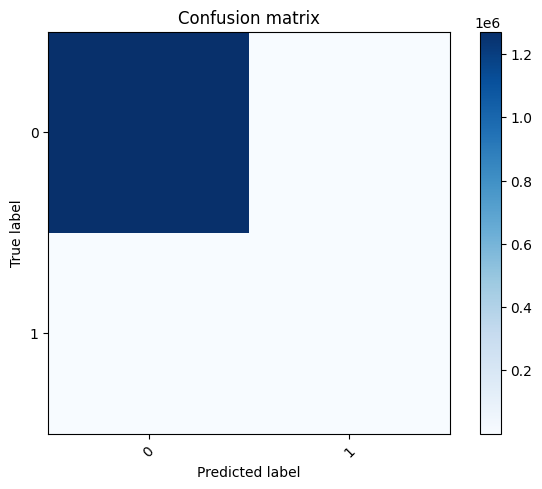

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.89      0.60      0.72      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.80      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524



In [39]:
# Compute confusion matrix
cm = confusion_matrix(y_true, relu_adam_model_FC_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, relu_adam_model_FC_pred))

### FC (Sigmoid + Adam)

[[1270810      94]
 [    744     876]]
Plotting confusion matrix


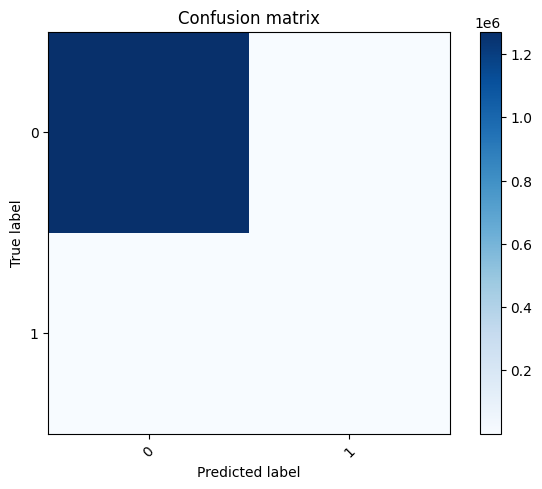

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.90      0.54      0.68      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.77      0.84   1272524
weighted avg       1.00      1.00      1.00   1272524



In [40]:
# Compute confusion matrix
cm = confusion_matrix(y_true, sigmoid_adam_model_FC_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, sigmoid_adam_model_FC_pred))

### FC (Tanh + Adam)

[[1270746     158]
 [    642     978]]
Plotting confusion matrix


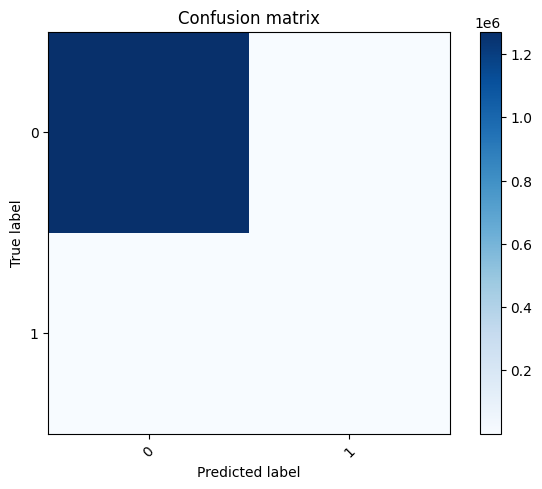

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.86      0.60      0.71      1620

    accuracy                           1.00   1272524
   macro avg       0.93      0.80      0.85   1272524
weighted avg       1.00      1.00      1.00   1272524



In [41]:
# Compute confusion matrix
cm = confusion_matrix(y_true, tanh_adam_model_FC_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, tanh_adam_model_FC_pred))

### (Relu + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

[[1270857      47]
 [    893     727]]
Plotting confusion matrix


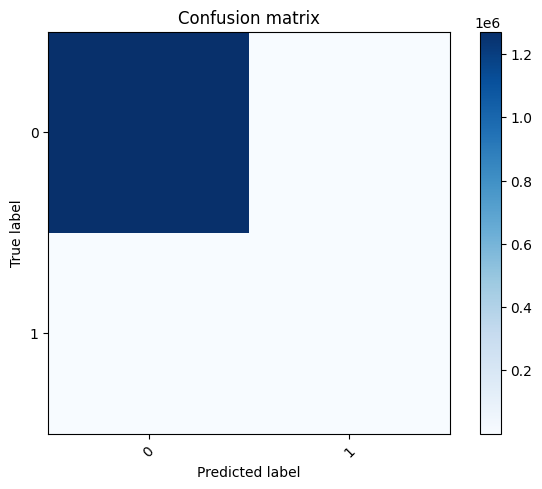

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.94      0.45      0.61      1620

    accuracy                           1.00   1272524
   macro avg       0.97      0.72      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



In [42]:
# Compute confusion matrix
cm = confusion_matrix(y_true, relu_adam_model_CNN_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, relu_adam_model_CNN_pred))

### (Relu + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

[[1270840      64]
 [    821     799]]
Plotting confusion matrix


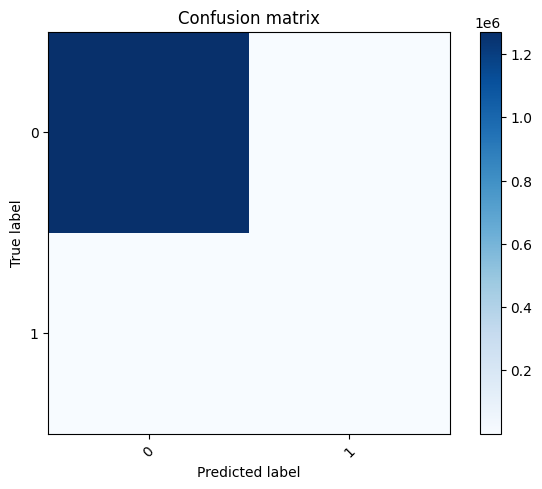

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.93      0.49      0.64      1620

    accuracy                           1.00   1272524
   macro avg       0.96      0.75      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



In [43]:
# Compute confusion matrix
cm = confusion_matrix(y_true, relu_sgd_model_CNN_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, relu_sgd_model_CNN_pred))

### (Sigmoid + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

In [44]:
# Compute confusion matrix
cm = confusion_matrix(y_true, sigmoid_adam_model_CNN_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, sigmoid_adam_model_CNN_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

### (Sigmoid + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

[[1270904       0]
 [   1620       0]]
Plotting confusion matrix


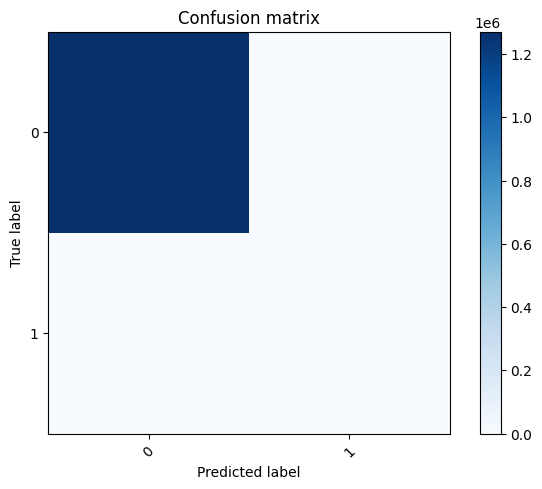

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.00      0.00      0.00      1620

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



In [45]:
# Compute confusion matrix
cm = confusion_matrix(y_true, sigmoid_sgd_model_CNN_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, sigmoid_sgd_model_CNN_pred))

### (Tanh + Adam + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

[[1270778     126]
 [    763     857]]
Plotting confusion matrix


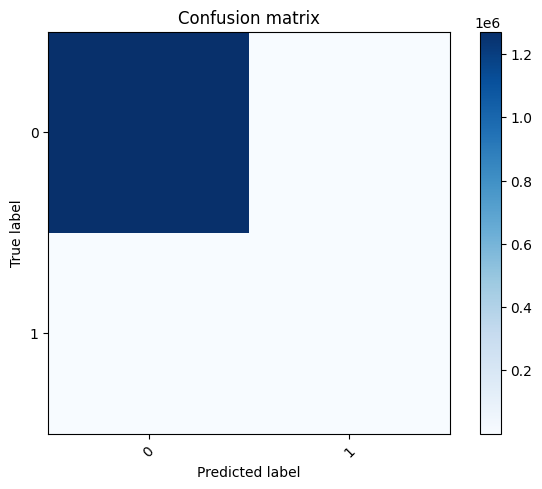

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.87      0.53      0.66      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.76      0.83   1272524
weighted avg       1.00      1.00      1.00   1272524



In [46]:
# Compute confusion matrix
cm = confusion_matrix(y_true, tanh_adam_model_CNN_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, tanh_adam_model_CNN_pred))

### (Tanh + SGD + 2 Convolution Layers with 32 and 64 kernals + Kernal Size: 1x5)

[[1270840      64]
 [    831     789]]
Plotting confusion matrix


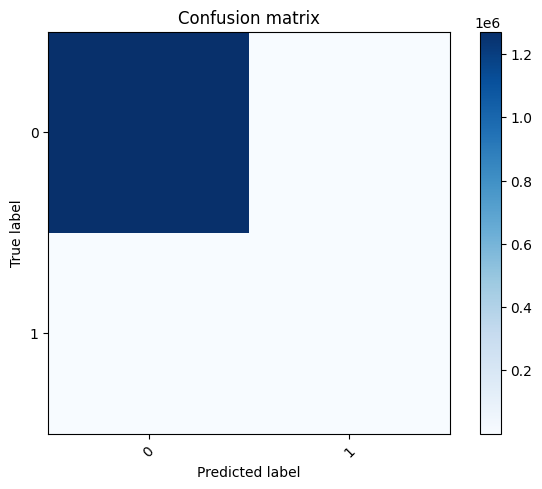

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.92      0.49      0.64      1620

    accuracy                           1.00   1272524
   macro avg       0.96      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



In [47]:
# Compute confusion matrix
cm = confusion_matrix(y_true, tanh_sgd_model_CNN_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, tanh_sgd_model_CNN_pred))

### CNN (Relu + Adam + 1 Convolution Layers with 64 kernals + Kernal Size: 1x5)

[[1270866      38]
 [    828     792]]
Plotting confusion matrix


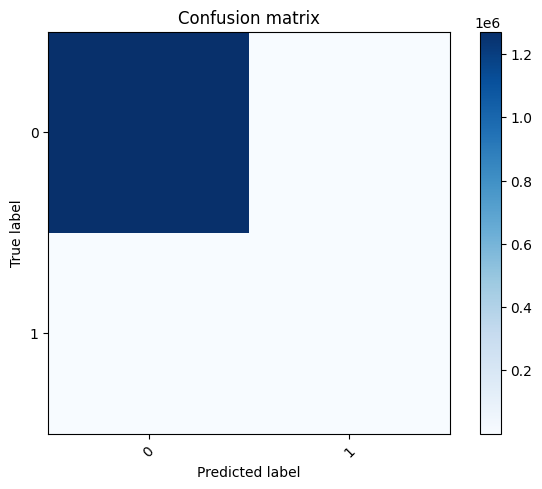

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.95      0.49      0.65      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



In [48]:
# Compute confusion matrix
cm = confusion_matrix(y_true, relu_adam_model_diff_CNN_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, binary_intrusion_data )
plt.show()

print(classification_report(y_true, relu_adam_model_diff_CNN_pred))